In [80]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import bambi as bmb 
import hssm
import os
import arviz as az 
import pymc as pm 
hssm.set_floatX("float32")

Setting PyTensor floatX type to float32.
Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


## Read data

In [93]:
def extract_data(fname):
    # Drop rows with missing data in column: 'means'
    if fname.endswith('csv'):
        data = pd.read_csv('data/'+fname)
        if len(data) != 587:
            # print(len(data))
            return None
    else: 
        return None

    try:
        data = data.dropna(subset=['means'])
        # Filter rows based on column: 'difference'
        data = data[data['difference'].notna()]
        # Select columns: 'means', 'direction' and 8 other columns
        if data['participant'].unique()[0]%3 == 0:
            data['key_resp'] = data['slider_resp_recorded_keyresp.keys']
            data['rt'] = data['slider_resp_recorded_keyresp.rt']
            data['cond'] = 'chart'
        elif data['participant'].unique()[0]%3 == 1:
            data['key_resp'] = data['numerical_choice_resp.keys']
            data['rt'] = data['numerical_choice_resp.rt']
            data['cond'] = 'slider'
        else:
            data['key_resp'] = data['slider_resp_recorded_keyresp_2.keys']
            data['rt'] = data['slider_resp_recorded_keyresp_2.rt']
            data['cond'] = 'numerical'

        data = data.loc[:, ['participant', 'means', 'direction', 'bumps', 'diff_dir', 'trials.thisN', 'difference', 'incorrect choice', 'key_resp', 'rt', 'cond']]
        data['accuracy'] = (data['incorrect choice'].values != data['key_resp'].values)
        data['response'] = -1
        data.loc[data['accuracy'], 'response'] = 1
    except:
        return None
    return data.reset_index(drop=True)

# data_clean = extract_data(data.copy())
# data_clean.head()

In [94]:
files = os.listdir('data/')
comb_data = pd.concat([extract_data(fname) for fname in files]).reset_index(drop=True)


In [97]:
comb_data

,participant,means,direction,bumps,diff_dir,trials.thisN,difference,incorrect choice,key_resp,rt,cond,accuracy,response
0,25353.0,64.0,1.0,single,1.0,0.0,8.0,left,left,3.881548,chart,False,-1
1,25353.0,48.0,1.0,noisy,-1.0,1.0,-6.0,right,right,7.387671,chart,False,-1
2,25353.0,53.0,1.0,noisy,-1.0,2.0,-10.0,left,right,6.337773,chart,True,1
3,25353.0,64.0,-1.0,center,-1.0,3.0,-8.0,left,right,3.151569,chart,True,1
4,25353.0,60.0,1.0,center,1.0,4.0,8.0,left,right,5.806216,chart,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11595,908388.0,60.0,1.0,noisy,-1.0,285.0,-8.0,left,left,2.442362,chart,False,-1
11596,908388.0,49.0,1.0,single,-1.0,286.0,-12.0,right,left,0.798230,chart,True,1
11597,908388.0,38.0,-1.0,single,-1.0,287.0,-11.0,left,right,0.681007,chart,True,1
11598,908388.0,62.0,-1.0,center,-1.0,288.0,-12.0,right,left,0.802785,chart,True,1


In [103]:
hssm_model = hssm.HSSM(data=comb_data[['rt', 'response', 'means', 'direction', 'bumps', 'diff_dir', 'difference']], 
            include=
            [{"name": "v",
              "formula": "v ~ direction + bumps + diff_dir + difference"}])

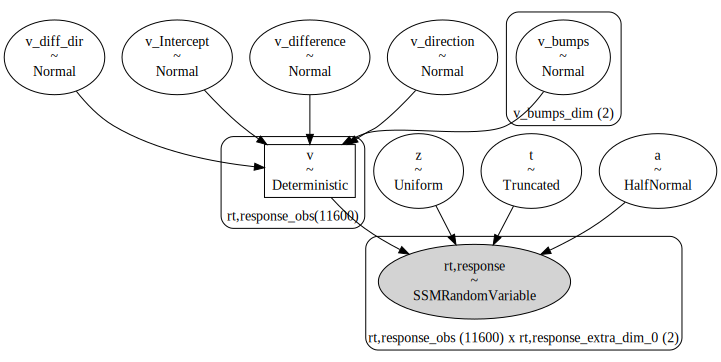

In [104]:
hssm_model.graph()

In [105]:
infer_data = hssm_model.sample()